# Traders@MIT Data Science Case 2024

You are a member of the fictional trading arm of Traders@MIT, and you are asked to present evidence that some hand-crafted signals can be used to create a profitable trading strategy. To do this, you will construct a trading strategy in the form of a `python` function. You will be given a small amount of data to train your models, and you will be evaluated on a large hidden dataset. Your objective is to maximize the t-statistic of your trading strategy.

More technical details are provided below:

You are given a training dataset (`"train.csv"`) which is a DataFrame with `200` rows, each representing a different moment in time. Each row has some number of columns labeled "regressor{i}" or "target{i}". For each row, "regressor{i}" represents the value of the $i$'th signal for the given tick. "target{i}" represents the return of the $i$'th stock, meaning if your position in stock $i$ is $\$X$ for the given tick, your PNL for that tick is $\$X \cdot \text{target\{i\}}$. You can use this dataset to learn how to predict the stock movements given your feature set.

You will write a `python` function called `strategy` which takes as input *only* the regressors in a row in a DataFrame, and returns as output a list-like object with the same length as the number of stocks. The output represents the dollar positions you wish to acquire in each stock, and they can be any real number. You may assume that you have no market impact, no trading costs, etc. Your submitted function will run on every row of the hidden DataFrame, and your score will be t-statistic of your PNL over all the ticks. A copy of the code that computes this score for the training set and an example trading strategy are provided below.

It is guaranteed that each tick is an independent generation of the same statistical process.

Please do not try to abuse floating point calculations (any `inf` scores will be turned into `0`). On that note, also make sure your code won't crash and will run under `10` seconds on `200,000` DataFrame rows and under `1` second on `200` DataFrame rows. Your function should also not remember things between calls. You are free to explore the dataset however you like, but your submission must only import from `numpy` and `pandas`. Feel free to omit `numpy` and `pandas` imports in your submission as they are imported as `np` and `pd` respectively automatically.

In [ ]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [ ]:
def tstat(returns):
    returns = np.array(returns)
    return np.mean(returns)/np.std(returns,ddof=1)*np.sqrt(len(returns))

In [ ]:
def score_trading_strategy(test_df, strategy_fn, score_fn=tstat):
    """
    test_df: pd.Dataframe where columns are named "regressor{i}" or "target{i}"
    strategy_fn: (row of test_df) -> [positions in each stock]
    score_fn: (list of returns) -> (scalar)
    """
    targets = [col for col in test_df if col.startswith("target")]
    X_df = test_df.drop(columns=targets)
    y_df = test_df[targets]

    positions = X_df.apply(strategy_fn, axis=1)
    returns = [np.dot(y_df.iloc[idx],pos) for idx,pos in enumerate(positions)]

    return score_fn(returns)

## Your Code Here:

In [ ]:
df = pd.read_csv("http://54.89.159.39:8080/data")
df = df.drop(columns=['Unnamed: 0'])
data = df.iloc[:140].copy()
display(data)

df.head()

,regressor1,regressor2,target1,target2
0,0.326782,0.499921,0.059320,0.075750
1,-0.047995,-0.152693,0.062291,0.041191
2,-0.615488,-0.579502,0.055793,-0.071521
3,-0.195270,-0.771140,-0.154022,0.174844
4,-0.528095,0.682407,0.017744,0.047182
...,...,...,...,...
135,0.168800,0.255910,0.018630,-0.018510
136,-0.047306,-0.431727,0.013609,0.044905
137,-0.219765,0.103735,0.006693,-0.031862
138,0.401837,-0.222796,0.014866,0.018118


,regressor1,regressor2,target1,target2
0,0.326782,0.499921,0.059320,0.075750
1,-0.047995,-0.152693,0.062291,0.041191
2,-0.615488,-0.579502,0.055793,-0.071521
3,-0.195270,-0.771140,-0.154022,0.174844
4,-0.528095,0.682407,0.017744,0.047182


In [ ]:
missing_values = data.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

# No missing values

Missing Values in Each Column:
 regressor1    0
regressor2    0
target1       0
target2       0
dtype: int64


In [ ]:
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap the outliers
    series_capped = series.clip(lower=lower_bound, upper=upper_bound)
    return series_capped

# Apply the function to each numerical column
for column in ['regressor1', 'regressor2', 'target1', 'target2']:
    data[column] = cap_outliers(data[column])
# No values removed due to outliers

In [ ]:
# Standardize regressors
for column in ['regressor1', 'regressor2']:
    mean = data[column].mean()
    std = data[column].std()
    data[column] = (data[column] - mean) / std
    print(f"\nStandardized {column}: Mean = {data[column].mean()}, Std = {data[column].std()}")
display(data.head())



Standardized regressor1: Mean = 1.2688263138573217e-17, Std = 1.0000000000000002

Standardized regressor2: Mean = 0.0, Std = 1.0


,regressor1,regressor2,target1,target2
0,0.864631,0.868785,0.059320,0.075750
1,-0.008391,-0.338365,0.062291,0.041191
2,-1.330335,-1.127841,0.055793,-0.071521
3,-0.351462,-1.482317,-0.127428,0.171365
4,-1.126758,1.206332,0.017744,0.047182


In [ ]:
summary_stats = data.describe()
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
          regressor1  regressor2     target1     target2
count  1.400000e+02  140.000000  140.000000  140.000000
mean   1.268826e-17    0.000000    0.005447   -0.006483
std    1.000000e+00    1.000000    0.060343    0.067874
min   -2.805543e+00   -1.905163   -0.127428   -0.179144
25%   -6.859159e-01   -0.689312   -0.025110   -0.047703
50%    4.705483e-02   -0.026448    0.012633   -0.003810
75%    7.271684e-01    0.802569    0.043103    0.039924
max    2.556953e+00    1.788494    0.145421    0.171365


In [ ]:
corr_matrix = data[['regressor1', 'regressor2', 'target1', 'target2']].corr()
print("\nCorrelation Matrix:\n", corr_matrix)


Correlation Matrix:
             regressor1  regressor2   target1   target2
regressor1    1.000000   -0.072895 -0.104058  0.314524
regressor2   -0.072895    1.000000  0.200777 -0.150854
target1      -0.104058    0.200777  1.000000  0.008240
target2       0.314524   -0.150854  0.008240  1.000000


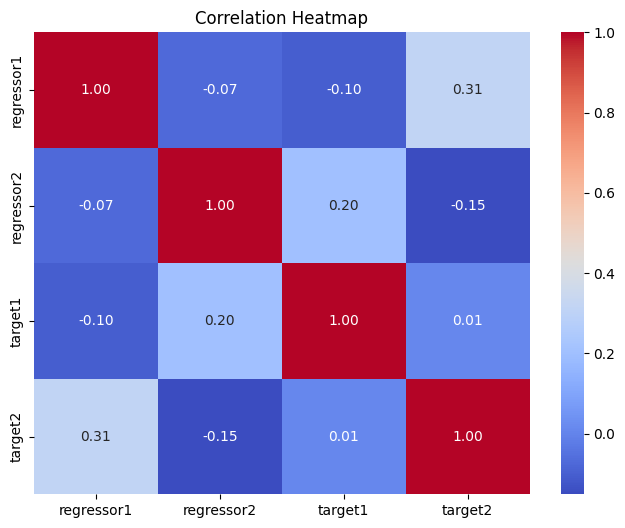

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of Correlations
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

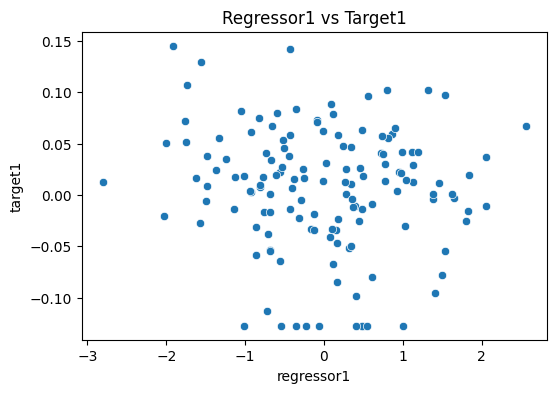

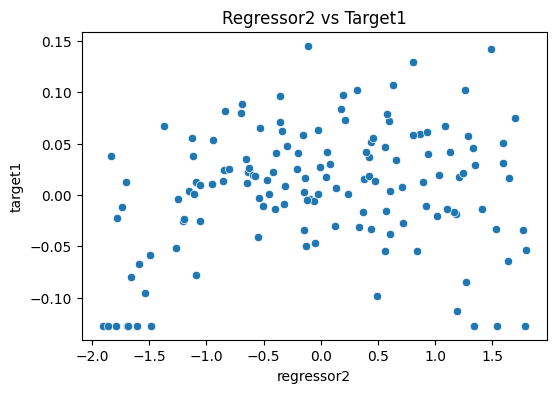

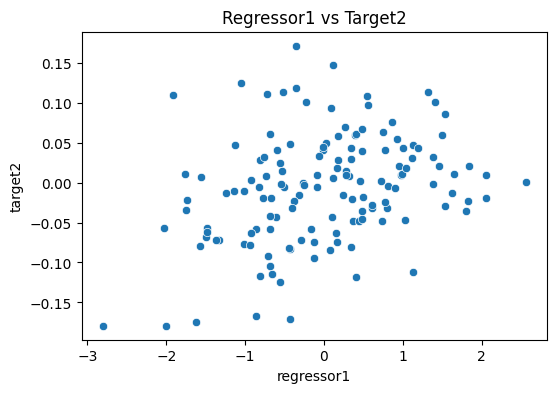

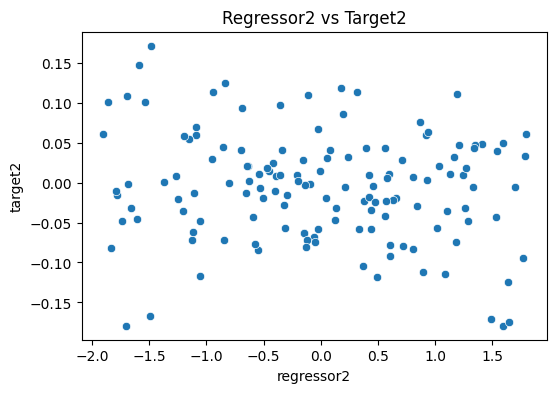

In [ ]:
# Scatter Plots between Regressors and Targets
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot for regressor1 vs target1
plt.figure(figsize=(6,4))
sns.scatterplot(x='regressor1', y='target1', data=data)
plt.title('Regressor1 vs Target1')
plt.show()

# Scatter plot for regressor2 vs target1
plt.figure(figsize=(6,4))
sns.scatterplot(x='regressor2', y='target1', data=data)
plt.title('Regressor2 vs Target1')
plt.show()

# Scatter plot for regressor1 vs target2
plt.figure(figsize=(6,4))
sns.scatterplot(x='regressor1', y='target2', data=data)
plt.title('Regressor1 vs Target2')
plt.show()

# Scatter plot for regressor2 vs target2
plt.figure(figsize=(6,4))
sns.scatterplot(x='regressor2', y='target2', data=data)
plt.title('Regressor2 vs Target2')
plt.show()


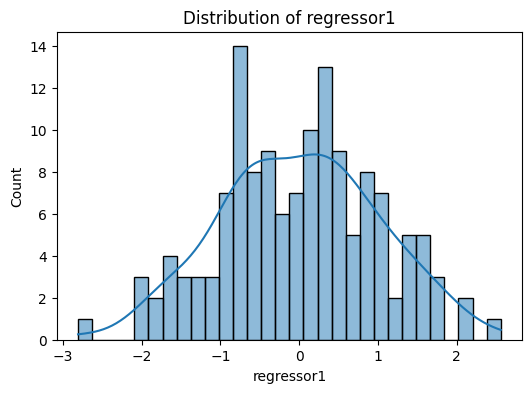

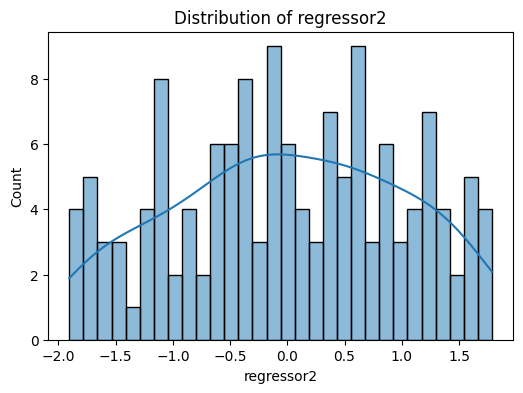

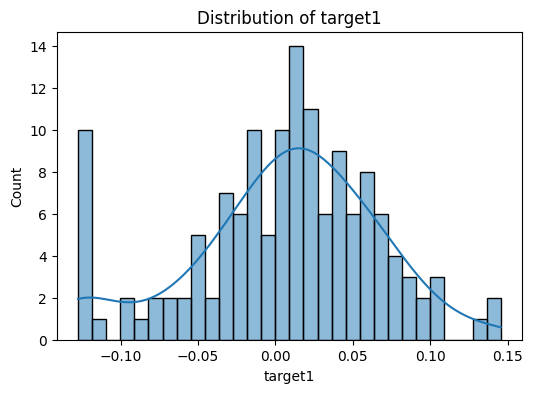

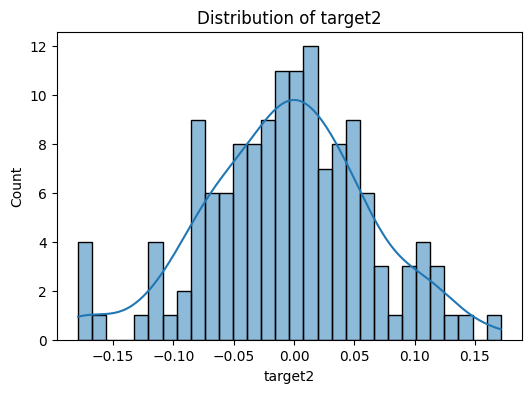

In [ ]:
# Distribution Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms with Kernel Density Estimate (KDE) for each column
for column in ['regressor1', 'regressor2', 'target1', 'target2']:
    plt.figure(figsize=(6,4))
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


train_df = data.copy()
test_df = df.iloc[140:].copy()


# 3.1. Create Interaction Term
train_df['regressor1_regressor2'] = train_df['regressor1'] * train_df['regressor2']
test_df['regressor1_regressor2'] = test_df['regressor1'] * test_df['regressor2']

# 3.2. Create Polynomial Features (Squared Terms)
train_df['regressor1_squared'] = train_df['regressor1'] ** 2
train_df['regressor2_squared'] = train_df['regressor2'] ** 2

test_df['regressor1_squared'] = test_df['regressor1'] ** 2
test_df['regressor2_squared'] = test_df['regressor2'] ** 2


# Define the feature columns including engineered features
feature_cols = ['regressor1', 'regressor2', 'regressor1_regressor2', 'regressor1_squared', 'regressor2_squared']

# ================================
# Step 5: Model Training and Validation
# ================================

# 5.1. Split Features and Targets for Training
X_train = train_df[feature_cols]
y_train_target1 = train_df['target1']
y_train_target2 = train_df['target2']

# Split Features and Targets for Testing
X_test = test_df[feature_cols]
y_test_target1 = test_df['target1']
y_test_target2 = test_df['target2']

# 5.2. Initialize Ridge Regression Models
ridge_target1 = Ridge(alpha=0.0001)
ridge_target2 = Ridge(alpha=0.0001)

# 5.3. Train the Models on Training Data
ridge_target1.fit(X_train, y_train_target1)
ridge_target2.fit(X_train, y_train_target2)

# 5.4. Cross-Validation to Evaluate Models

# Function to compute RMSE from cross_val_score
def compute_cv_rmse(model, X, y, cv=5):
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-cv_scores.mean())
    return rmse

# Compute Cross-Validated RMSE for Target1
cv_rmse_target1 = compute_cv_rmse(ridge_target1, X_train, y_train_target1, cv=5)
print(f"Cross-Validated RMSE for Target 1: {cv_rmse_target1:.5f}")

# Compute Cross-Validated RMSE for Target2
cv_rmse_target2 = compute_cv_rmse(ridge_target2, X_train, y_train_target2, cv=5)
print(f"Cross-Validated RMSE for Target 2: {cv_rmse_target2:.5f}")

# 5.5. Predict on Test Set
y_pred_target1 = ridge_target1.predict(X_test)
y_pred_target2 = ridge_target2.predict(X_test)

# 5.6. Calculate Test RMSE
test_rmse_target1 = mean_squared_error(y_test_target1, y_pred_target1, squared=False)
test_rmse_target2 = mean_squared_error(y_test_target2, y_pred_target2, squared=False)
print(f"Test RMSE for Target 1: {test_rmse_target1:.5f}")
print(f"Test RMSE for Target 2: {test_rmse_target2:.5f}")


# Extract coefficients and intercepts for Target 1
intercept_t1 = ridge_target1.intercept_
coef_t1 = ridge_target1.coef_

# Map coefficients to feature names for Target 1
coef_t1_dict = dict(zip(feature_cols, coef_t1))

# Extract coefficients and intercepts for Target 2
intercept_t2 = ridge_target2.intercept_
coef_t2 = ridge_target2.coef_

# Map coefficients to feature names for Target 2
coef_t2_dict = dict(zip(feature_cols, coef_t2))






Cross-Validated RMSE for Target 1: 0.05398
Cross-Validated RMSE for Target 2: 0.06580
Test RMSE for Target 1: 0.08304
Test RMSE for Target 2: 0.07983


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Example Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(df[["regressor1"]], df["target1"])

print(model.coef_, model.intercept_)

[-0.00749641] 0.0007732869385021894


In [ ]:
for reg in ['regressor1', 'regressor2']:
    mean = train_df[reg].mean()
    std = train_df[reg].std()
    print(f"{reg} - Mean: {mean:.5f}, Std Dev: {std:.5f}")

regressor1 - Mean: 0.00000, Std Dev: 1.00000
regressor2 - Mean: 0.00000, Std Dev: 1.00000


In [ ]:
from sklearn.linear_model import ElasticNet

train_df = data.copy()
test_df = df.iloc[140:].copy()


# 3.1. Create Interaction Term
train_df['regressor1_regressor2'] = train_df['regressor1'] * train_df['regressor2']

# 3.2. Create Polynomial Features (Squared Terms)
train_df['regressor1_squared'] = train_df['regressor1'] ** 2
train_df['regressor2_squared'] = train_df['regressor2'] ** 2


# Define the feature columns including engineered features
feature_cols = ['regressor1', 'regressor2', 'regressor1_regressor2', 'regressor1_squared', 'regressor2_squared']

# ================================
# Ridge Regression
# ================================

# 5.1. Split Features and Targets for Training
X_train = train_df[feature_cols]
y_train_target1 = train_df['target1']
y_train_target2 = train_df['target2']


# 5.2. Initialize Ridge Regression Models
ridge_target1 = Ridge(alpha= 120)
ridge_target2 = Ridge(alpha=120)

# 5.3. Train the Models on Training Data
ridge_target1.fit(X_train, y_train_target1)
ridge_target2.fit(X_train, y_train_target2)


# Feature columns used in the models
feature_cols = ['regressor1', 'regressor2', 'regressor1_regressor2', 'regressor1_squared', 'regressor2_squared']

# Extract coefficients and intercepts for Target 1
intercept_t1 = ridge_target1.intercept_
coef_t1 = ridge_target1.coef_

# Map coefficients to feature names for Target 1
coef_t1_dict = dict(zip(feature_cols, coef_t1))

# Extract coefficients and intercepts for Target 2
intercept_t2 = ridge_target2.intercept_
coef_t2 = ridge_target2.coef_

# Map coefficients to feature names for Target 2
coef_t2_dict = dict(zip(feature_cols, coef_t2))

# Print coefficients and intercepts for Target 1
print("Coefficients for Target 1:")
print(f"t1_intercept = {intercept_t1}")
for feature, coef in coef_t1_dict.items():
    print(f"t1_{feature} = {coef}")

# Print coefficients and intercepts for Target 2
print("\nCoefficients for Target 2:")
print(f"t2_intercept = {intercept_t2}")
for feature, coef in coef_t2_dict.items():
    print(f"t2_{feature} = {coef}")


# Lasso Model
from sklearn.linear_model import Lasso

# Define a range of alpha values for Lasso
alpha_values_lasso = np.logspace(-3, 1, 50)  # Alphas from 0.001 to 10

# Define the parameter grid for Lasso
param_grid_lasso = {'alpha': alpha_values_lasso}

# Grid Search for Target 1 (Lasso)
lasso = Lasso(max_iter=10000)
grid_search_lasso_t1 = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso,
                                    scoring='neg_mean_squared_error', cv=5)

grid_search_lasso_t1.fit(X_train, y_train_target1)
best_alpha_lasso_t1 = grid_search_lasso_t1.best_params_['alpha']
print(f"\nBest alpha for Lasso Target 1: {best_alpha_lasso_t1}")

# Retrain the Lasso model with the best alpha
lasso_target1 = Lasso(alpha=best_alpha_lasso_t1, max_iter=10000)
lasso_target1.fit(X_train, y_train_target1)

# Extract coefficients and intercepts for Lasso Target 1
intercept_lasso_t1 = lasso_target1.intercept_
coef_lasso_t1 = lasso_target1.coef_
coef_lasso_t1_dict = dict(zip(feature_cols, coef_lasso_t1))

# Print coefficients and intercepts for Lasso Target 1
print("\nLasso Coefficients for Target 1:")
print(f"t1_intercept = {intercept_lasso_t1}")
for feature, coef in coef_lasso_t1_dict.items():
    print(f"t1_{feature} = {coef}")

# Grid Search for Target 2 (Lasso)
lasso = Lasso(max_iter=10000)
grid_search_lasso_t2 = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid_lasso,
    scoring='neg_mean_squared_error',
    cv=5
)
grid_search_lasso_t2.fit(X_train, y_train_target2)
best_alpha_lasso_t2 = grid_search_lasso_t2.best_params_['alpha']
print(f"\nBest alpha for Lasso Target 2: {best_alpha_lasso_t2}")

# Retrain the Lasso model with the best alpha for Target 2
lasso_target2 = Lasso(alpha=best_alpha_lasso_t2, max_iter=10000)
lasso_target2.fit(X_train, y_train_target2)

# Extract coefficients and intercepts for Lasso Target 2
intercept_lasso_t2 = lasso_target2.intercept_
coef_lasso_t2 = lasso_target2.coef_
coef_lasso_t2_dict = dict(zip(feature_cols, coef_lasso_t2))

# Print coefficients and intercepts for Lasso Target 2
print("\nLasso Coefficients for Target 2:")
print(f"t2_intercept = {intercept_lasso_t2}")
for feature, coef in coef_lasso_t2_dict.items():
    print(f"t2_{feature} = {coef}")

# Elastic net regressoion

# Define a range of alpha values and l1_ratio values for Elastic Net
alpha_values_enet = np.logspace(-3, 1, 50)  # Alphas from 0.001 to 10
l1_ratio_values = np.linspace(0, 1, 10)     # l1_ratio from 0 (Ridge) to 1 (Lasso)

# Define the parameter grid for Elastic Net
param_grid_enet = {'alpha': alpha_values_enet, 'l1_ratio': l1_ratio_values}


# Grid Search for Target 1 (Elastic Net)
enet = ElasticNet(max_iter=10000)
grid_search_enet_t1 = GridSearchCV(
    estimator=enet,
    param_grid=param_grid_enet,
    scoring='neg_mean_squared_error',
    cv=5
)
grid_search_enet_t1.fit(X_train, y_train_target1)

# Get the best parameters for Elastic Net Target 1
best_params_enet_t1 = grid_search_enet_t1.best_params_
best_alpha_enet_t1 = best_params_enet_t1['alpha']
best_l1_ratio_t1 = best_params_enet_t1['l1_ratio']

# Retrain the Elastic Net model with the best parameters
enet_target1 = ElasticNet(alpha=100, l1_ratio=best_l1_ratio_t1, max_iter=10000)
enet_target1.fit(X_train, y_train_target1)

# Extract coefficients and intercepts for Elastic Net Target 1
intercept_enet_t1 = enet_target1.intercept_
coef_enet_t1 = enet_target1.coef_
coef_enet_t1_dict = dict(zip(feature_cols, coef_enet_t1))

# Print coefficients and intercepts for Elastic Net Target 1
print("\nElastic Net Coefficients for Target 1:")
print(f"t1_intercept = {intercept_enet_t1}")
for feature, coef in coef_enet_t1_dict.items():
    print(f"t1_{feature} = {coef}")

# Grid Search for Target 2 (Elastic Net)
enet = ElasticNet(max_iter=10000)
grid_search_enet_t2 = GridSearchCV(
    estimator=enet,
    param_grid=param_grid_enet,
    scoring='neg_mean_squared_error',
    cv=5
)
grid_search_enet_t2.fit(X_train, y_train_target2)

# Get the best parameters for Elastic Net Target 2
best_params_enet_t2 = grid_search_enet_t2.best_params_
best_alpha_enet_t2 = best_params_enet_t2['alpha']
best_l1_ratio_t2 = best_params_enet_t2['l1_ratio']

# Retrain the Elastic Net model with the best parameters
enet_target2 = ElasticNet(alpha=100, l1_ratio=best_l1_ratio_t2, max_iter=10000)
enet_target2.fit(X_train, y_train_target2)

# Extract coefficients and intercepts for Elastic Net Target 2
intercept_enet_t2 = enet_target2.intercept_
coef_enet_t2 = enet_target2.coef_
coef_enet_t2_dict = dict(zip(feature_cols, coef_enet_t2))

# Print coefficients and intercepts for Elastic Net Target 2
print("\nElastic Net Coefficients for Target 2:")
print(f"t2_intercept = {intercept_enet_t2}")
for feature, coef in coef_enet_t2_dict.items():
    print(f"t2_{feature} = {coef}")



Coefficients for Target 1:
t1_intercept = 0.014418117259013551
t1_regressor1 = -0.003747266048839492
t1_regressor2 = 0.005796602473792974
t1_regressor1_regressor2 = 0.00018175780498793533
t1_regressor1_squared = 0.0055730665052173755
t1_regressor2_squared = -0.014595061851828843

Coefficients for Target 2:
t2_intercept = 0.0003096412571576782
t2_regressor1 = 0.011114885434612996
t2_regressor2 = -0.005291074222280544
t2_regressor1_regressor2 = -0.0009085532808180965
t2_regressor1_squared = -0.00596125374195668
t2_regressor2_squared = -0.0009466191083963291

Best alpha for Lasso Target 1: 0.0012067926406393288

Lasso Coefficients for Target 1:
t1_intercept = 0.023154229643352165
t1_regressor1 = -0.006467937626720764
t1_regressor2 = 0.008490843411877507
t1_regressor1_regressor2 = -0.0
t1_regressor1_squared = 0.007620922502633271
t1_regressor2_squared = -0.02545512911038467

Best alpha for Lasso Target 2: 0.004498432668969444

Lasso Coefficients for Target 2:
t2_intercept = -0.000332573168

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e-01, tolerance: 4.117e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.306e-01, tolerance: 4.124e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


Elastic Net Coefficients for Target 1:
t1_intercept = 0.005447410225656136
t1_regressor1 = -0.0
t1_regressor2 = 0.0
t1_regressor1_regressor2 = 0.0
t1_regressor1_squared = 0.0
t1_regressor2_squared = -0.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e-01, tolerance: 4.795e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.042e-01, tolerance: 4.761e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


Elastic Net Coefficients for Target 2:
t2_intercept = -0.006483134152720453
t2_regressor1 = 0.0
t2_regressor2 = -0.0
t2_regressor1_regressor2 = -0.0
t2_regressor1_squared = -0.0
t2_regressor2_squared = -0.0


In [ ]:
def strategy(row):
    import numpy as np
    import pandas as pd


    # Hard-coded coefficients for Target 1
    t1_intercept = 0.005447410225656136
    t1_regressor1 = -0.0
    t1_regressor2 = 0.0
    t1_regressor1_regressor2 = 0.0
    t1_regressor1_squared = 0.0
    t1_regressor2_squared = -0.0


    # Hard-coded coefficients for Target 2
    t2_intercept = -0.006483134152720453
    t2_regressor1 = 0.0
    t2_regressor2 = -0.0
    t2_regressor1_regressor2 = -0.0
    t2_regressor1_squared = -0.0
    t2_regressor2_squared = -0.0

    # Extract regressor values
    reg1 = row["regressor1"]
    reg2 = row["regressor2"]

    # Feature engineering
    reg1_reg2 = reg1 * reg2
    reg1_squared = reg1 ** 2
    reg2_squared = reg2 ** 2

    # Predict target returns for Target 1
    predicted_target1 = (
        t1_intercept +
        t1_regressor1 * reg1 +
        t1_regressor2 * reg2 +
        t1_regressor1_regressor2 * reg1_reg2 +
        t1_regressor1_squared * reg1_squared +
        t1_regressor2_squared * reg2_squared
    )

    # Predict target returns for Target 2
    predicted_target2 = (
        t2_intercept +
        t2_regressor1 * reg1 +
        t2_regressor2 * reg2 +
        t2_regressor1_regressor2 * reg1_reg2 +
        t2_regressor1_squared * reg1_squared +
        t2_regressor2_squared * reg2_squared
    )

    # Decide on positions based on predicted returns
    position_t1 = np.sign(predicted_target1)
    position_t2 = np.sign(predicted_target2)

    return [position_t1, position_t2]


In [ ]:
t_stat = score_trading_strategy(test_df, strategy)
print(f"T-Statistic of PNL: {t_stat:.5f}")

T-Statistic of PNL: 0.36951


In [ ]:
# Import necessary modules
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define a range of alpha values to test
alpha_values = np.logspace(-3, 3, 50)  # Alphas from 0.001 to 1000

# Define the parameter grid
param_grid = {'alpha': alpha_values}

# ================================
# Grid Search for Target 1
# ================================

# Initialize Ridge Regression model
ridge = Ridge()

# Perform grid search with cross-validation for Target 1
grid_search_t1 = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_t1.fit(X_train, y_train_target1)

# Get the best alpha value for Target 1
best_alpha_t1 = grid_search_t1.best_params_['alpha']
print(f"Best alpha for Target 1: {best_alpha_t1}")

# Retrain the model with the best alpha
ridge_target1 = Ridge(alpha=best_alpha_t1)
ridge_target1.fit(X_train, y_train_target1)

# Extract coefficients and intercepts for Target 1
intercept_t1 = ridge_target1.intercept_
coef_t1 = ridge_target1.coef_
coef_t1_dict = dict(zip(feature_cols, coef_t1))

# Print updated coefficients and intercepts for Target 1
print("\nUpdated Coefficients for Target 1:")
print(f"t1_intercept = {intercept_t1}")
for feature, coef in coef_t1_dict.items():
    print(f"t1_{feature} = {coef}")

# ================================
# Grid Search for Target 2
# ================================

# Perform grid search with cross-validation for Target 2
grid_search_t2 = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_t2.fit(X_train, y_train_target2)

# Get the best alpha value for Target 2
best_alpha_t2 = grid_search_t2.best_params_['alpha']
print(f"\nBest alpha for Target 2: {best_alpha_t2}")

# Retrain the model with the best alpha
ridge_target2 = Ridge(alpha=best_alpha_t2)
ridge_target2.fit(X_train, y_train_target2)

# Extract coefficients and intercepts for Target 2
intercept_t2 = ridge_target2.intercept_
coef_t2 = ridge_target2.coef_
coef_t2_dict = dict(zip(feature_cols, coef_t2))

# Print updated coefficients and intercepts for Target 2
print("\nUpdated Coefficients for Target 2:")
print(f"t2_intercept = {intercept_t2}")
for feature, coef in coef_t2_dict.items():
    print(f"t2_{feature} = {coef}")


Best alpha for Target 1: 10.985411419875572

Updated Coefficients for Target 1:
t1_intercept = 0.02208763439027552
t1_regressor1 = -0.00701867358811126
t1_regressor2 = 0.009034408404595032
t1_regressor1_regressor2 = 2.3437504703830384e-05
t1_regressor1_squared = 0.007981267657727602
t1_regressor2_squared = -0.0247394971996713

Best alpha for Target 2: 14.563484775012444

Updated Coefficients for Target 2:
t2_intercept = 0.0031957487910865183
t2_regressor1 = 0.018409690850254398
t2_regressor2 = -0.008642772506044286
t2_regressor1_regressor2 = -0.0017166744663436617
t2_regressor1_squared = -0.008508464720577286
t2_regressor2_squared = -0.0013651866308077541
